### purpose

Answer Question 2 of the manuscript - How is offset performance affected by the proportion of clinal alleles in the data?

In [1]:
from pythonimports import *
from myfigs import slope_graph, adjust_box_widths, save_pdf

import MVP_summary_functions as mvp

import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import levene  # brown-forsythe test of equal variance
plt.rcParams.update({'font.family' : 'serif'})

t0 = dt.now()  # notebook timer

summarydir = '/work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/01_Q1'
figdir = makedir(op.join(summarydir, 'figs'))
pkldir = '/work/lotterhos/MVP-Offsets/run_20220919/summaries/all_performance_dicts'

mvp.latest_commit()
session_info.show()

#########################################################
Today:	November 10, 2023 - 16:00:37 EST
python version: 3.8.5
conda env: mvp_env

Current commit of pythonimports:
commit 419895d157c97717f835390196c13cf973d25eba  
Merge: e20434f 1e09b6c  
Author: Brandon Lind <lind.brandon.m@gmail.com>

Current commit of MVP_offsets:
commit 782ee79eada654ce337935bf61a0984cd76dd9cf  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Wed Oct 4 14:13:12 2023 -0400
#########################################################



In [2]:
# get bcs data
bcs = mvp.combine_level_dicts(use_bcs_data=True)

filtering criteria:
	use_bcs_data = True
	performance = garden_performance
	num_traits = 2
	ntraits = None
	marker_set = all
	remove_structcrxn = False
	keep_nuisance = False
	remove_rda_outliers = True


reading reps: 100%|███████████████| 10/10 [00:19<00:00,  1.94s/it]


0-225
	 RONA num seeds =  180
	 lfmm2 num seeds =  180
	 GF num seeds =  180
	 rda num seeds =  180


225-450
	 RONA num seeds =  180
	 lfmm2 num seeds =  180
	 GF num seeds =  180
	 rda num seeds =  180


450-675
	 RONA num seeds =  180
	 lfmm2 num seeds =  180
	 GF num seeds =  180
	 rda num seeds =  180


675-900
	 RONA num seeds =  180
	 lfmm2 num seeds =  180
	 GF num seeds =  180
	 rda num seeds =  180


900-1125
	 RONA num seeds =  180
	 lfmm2 num seeds =  180
	 GF num seeds =  180
	 rda num seeds =  180


1125-1350
	 RONA num seeds =  180
	 lfmm2 num seeds =  180
	 GF num seeds =  180
	 rda num seeds =  180


1350-1575
	 RONA num seeds =  180
	 lfmm2 num seeds =  180
	 GF num seeds =  180
	 rda num seeds =  180


1575-1800
	 RONA num seeds =  180
	 lfmm2 num seeds =  180
	 GF num seeds =  180
	 rda num seeds =  180


1800-2025
	 RONA num seeds =  180
	 lfmm2 num seeds =  180
	 GF num seeds =  180
	 rda num seeds =  180


2025-2250
	 RONA num seeds =  180
	 lfmm2 num seeds =  18

In [3]:
# coombine programs into one dataframe
bcs_garden_data = mvp.combine_program_data(bcs)

bcs_garden_data.shape

(1080000, 27)

In [4]:
programs = bcs_garden_data.program.unique().tolist()

programs

['RONA-sal_opt',
 'RONA-temp_opt',
 'lfmm2',
 'GF',
 'rda-nocorr',
 'rda-structcorr']

In [5]:
# FORMULA BUILDING
formulas = {
    # same as 'simple' but without `slevel`
    'super_simple' : 'score ~ cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs',
}

# set up blank dictionaries to fill in later
lms = {}  # linear models
res = {}  # anova output
sos = {}  # rank of factors

In [6]:
import importlib
importlib.reload(sys.modules['MVP_summary_functions'])

import MVP_summary_functions as mvp

In [23]:
def print_summary_table(lm):
    """Do lm.summary2().__repr__() but just display the first table in lm.summary2().tables.
    
    summary - return from lm.summary2()
    """
    from statsmodels.iolib.summary2 import _simple_tables, _measure_tables

    summary = lm.summary2()
    
    tables = [summary.tables[0]]
    settings = [summary.settings[0]]
    pad_col, pad_index, widest = _measure_tables(tables, settings)
    rule_equal = widest * '='

    simple_tables = _simple_tables(tables, settings, pad_col, pad_index)
    tab = [x.as_text() for x in simple_tables]

    tab = '\n'.join(tab)
    tab = tab.split('\n')
    tab[0] = rule_equal
    tab.append(rule_equal)
    tab = '\n'.join(tab)
    
    print(tab)
    
    pass


def get_anova(formula_key, typ=None):
    """Estimate ANOVA using evolutionary parameters as factors.
    
    Parameters
    ----------
    formula_key : str
        used to index formulas just above
    typ : int
        the Type of ANOVA - 1, 2, or 3
    
    Notes
    -----
    - displays statistical info from ANOVA and qqplot
    - C(factor) treats a numerical entry as a category (gardens are integer IDs)
    """
    # determine formula
    formula = formulas[formula_key]
    
    # determine Type of ANOVA
    if typ is None:
        typ = 3 if 'interaction' in formula_key else 2
    
    # get anovas
    lms = {}
    res = {}
    sos = []
    for program in bcs_garden_data.program.unique():
        _df = bcs_garden_data[bcs_garden_data.program == program].copy()

        print(f'\n{ColorText(formula_key).bold()} {ColorText(formula).blue()}')
        print(f'{ColorText(mvp.factor_names[program]).green().bold()}')

        # perform type 2 anova
        lms[program] = ols(formula, data=_df).fit()
        res[program] = anova_lm(lms[program], typ=typ)
        
        # get percentages for sum of squares
        res[program]['perc_sum_sq'] = (
            (
                (res[program]['sum_sq'] / res[program]['sum_sq'].sum()) * 100
            ).round(2)
        )
        if round(abs(res[program]['perc_sum_sq'].sum() - 100), 2) > 0.03:  # account for compounding error rounding percs
            raise Exception('bad percentage', abs(res[program]['perc_sum_sq'].sum() - 100))

        res[program].index = res[program].index.map(mvp.factor_names)

        # brown-forsythe test?
        # TODO?

        # show more info
        display(res[program])
        print_summary_table(lms[program])

        sm.qqplot(lms[program].resid, line="45")
        plt.show()

        # get sum of squares
        sos.append(
            pd.Series(
                res[program]['sum_sq'].tolist(),
                name=program,
                index=res[program]['sum_sq'].index#.map(mvp.factor_names)
            )
        )
        
    return lms, res, sos


super_simple score ~ cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs
RONA (Env2)


,sum_sq,df,F,PR(>F),perc_sum_sq
"$p_{cQTN, temp}$",11.076279,1.0,203.959434,3.027995e-46,0.11
"$p_{cQTN, Env2}$",7.130868,1.0,131.308340,2.171984e-30,0.07
"$p_{cNeut, temp}$",350.186388,1.0,6448.358576,0.000000e+00,3.40
"$p_{cNeut, Env2}$",165.769820,1.0,3052.497975,0.000000e+00,1.61
Residual,9774.859470,179995.0,NaN,NaN,94.82


Model:              OLS              Adj. R-squared:     0.137      
Dependent Variable: score            AIC:                -13537.8899
Date:               2023-11-10 16:02 BIC:                -13487.3864
No. Observations:   180000           Log-Likelihood:     6773.9     
Df Model:           4                F-statistic:        7157.      
Df Residuals:       179995           Prob (F-statistic): 0.00       
R-squared:          0.137            Scale:              0.054306   


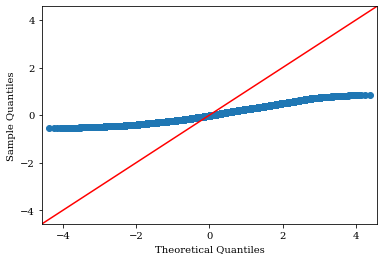


super_simple score ~ cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs
RONA (temp)


,sum_sq,df,F,PR(>F),perc_sum_sq
"$p_{cQTN, temp}$",461.435097,1.0,6854.545092,0.000000e+00,3.54
"$p_{cQTN, Env2}$",321.669143,1.0,4778.344045,0.000000e+00,2.47
"$p_{cNeut, temp}$",21.729532,1.0,322.788745,4.136405e-72,0.17
"$p_{cNeut, Env2}$",119.950781,1.0,1781.849799,0.000000e+00,0.92
Residual,12116.925221,179995.0,NaN,NaN,92.91


Model:              OLS              Adj. R-squared:     0.047     
Dependent Variable: score            AIC:                25124.2245
Date:               2023-11-10 16:02 BIC:                25174.7280
No. Observations:   180000           Log-Likelihood:     -12557.   
Df Model:           4                F-statistic:        2213.     
Df Residuals:       179995           Prob (F-statistic): 0.00      
R-squared:          0.047            Scale:              0.067318  


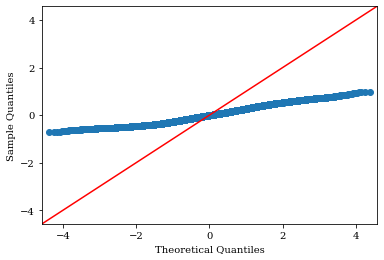


super_simple score ~ cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs
LFMM2


,sum_sq,df,F,PR(>F),perc_sum_sq
"$p_{cQTN, temp}$",256.979852,1.0,8357.260709,0.0,3.72
"$p_{cQTN, Env2}$",173.645491,1.0,5647.137802,0.0,2.51
"$p_{cNeut, temp}$",718.499204,1.0,23366.365591,0.0,10.40
"$p_{cNeut, Env2}$",227.994551,1.0,7414.627593,0.0,3.30
Residual,5534.718859,179995.0,NaN,NaN,80.08


Model:              OLS              Adj. R-squared:     0.173       
Dependent Variable: score            AIC:                -115917.0223
Date:               2023-11-10 16:02 BIC:                -115866.5188
No. Observations:   180000           Log-Likelihood:     57964.      
Df Model:           4                F-statistic:        9401.       
Df Residuals:       179995           Prob (F-statistic): 0.00        
R-squared:          0.173            Scale:              0.030749    


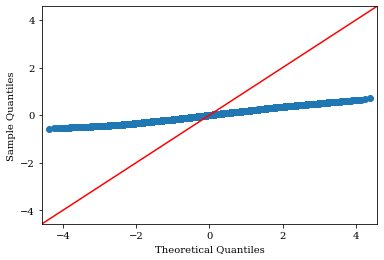


super_simple score ~ cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs
Gradient Forests


,sum_sq,df,F,PR(>F),perc_sum_sq
"$p_{cQTN, temp}$",350.833368,1.0,9184.348121,0.0,3.69
"$p_{cQTN, Env2}$",210.540691,1.0,5511.673549,0.0,2.21
"$p_{cNeut, temp}$",375.213154,1.0,9822.578289,0.0,3.94
"$p_{cNeut, Env2}$",1702.524610,1.0,44569.816059,0.0,17.89
Residual,6875.637914,179995.0,NaN,NaN,72.26


Model:              OLS              Adj. R-squared:     0.289      
Dependent Variable: score            AIC:                -76867.1644
Date:               2023-11-10 16:02 BIC:                -76816.6608
No. Observations:   180000           Log-Likelihood:     38439.     
Df Model:           4                F-statistic:        1.827e+04  
Df Residuals:       179995           Prob (F-statistic): 0.00       
R-squared:          0.289            Scale:              0.038199   


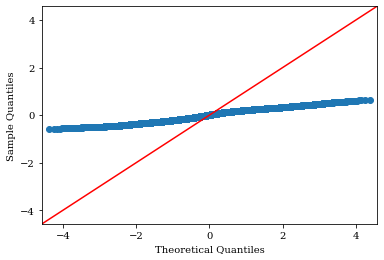


super_simple score ~ cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs
RDA-uncorrected


,sum_sq,df,F,PR(>F),perc_sum_sq
"$p_{cQTN, temp}$",326.478563,1.0,8168.479995,0.0,3.29
"$p_{cQTN, Env2}$",171.117641,1.0,4281.356235,0.0,1.72
"$p_{cNeut, temp}$",589.314088,1.0,14744.613849,0.0,5.93
"$p_{cNeut, Env2}$",1649.284886,1.0,41265.038898,0.0,16.61
Residual,7194.056785,179995.0,NaN,NaN,72.45


Model:              OLS              Adj. R-squared:     0.313      
Dependent Variable: score            AIC:                -68718.4182
Date:               2023-11-10 16:02 BIC:                -68667.9147
No. Observations:   180000           Log-Likelihood:     34364.     
Df Model:           4                F-statistic:        2.055e+04  
Df Residuals:       179995           Prob (F-statistic): 0.00       
R-squared:          0.313            Scale:              0.039968   


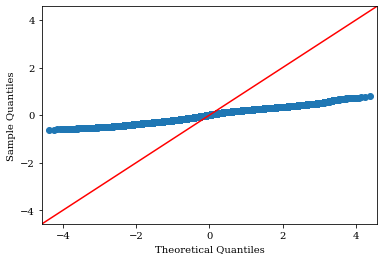


super_simple score ~ cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs
RDA-corrected


,sum_sq,df,F,PR(>F),perc_sum_sq
"$p_{cQTN, temp}$",36.345449,1.0,970.987128,1.344472e-212,0.48
"$p_{cQTN, Env2}$",26.680765,1.0,712.790185,1.002191e-156,0.35
"$p_{cNeut, temp}$",281.267846,1.0,7514.213388,0.000000e+00,3.70
"$p_{cNeut, Env2}$",512.076667,1.0,13680.388309,0.000000e+00,6.74
Residual,6737.472479,179995.0,NaN,NaN,88.72


Model:              OLS              Adj. R-squared:     0.276      
Dependent Variable: score            AIC:                -80521.0880
Date:               2023-11-10 16:02 BIC:                -80470.5844
No. Observations:   180000           Log-Likelihood:     40266.     
Df Model:           4                F-statistic:        1.716e+04  
Df Residuals:       179995           Prob (F-statistic): 0.00       
R-squared:          0.276            Scale:              0.037431   


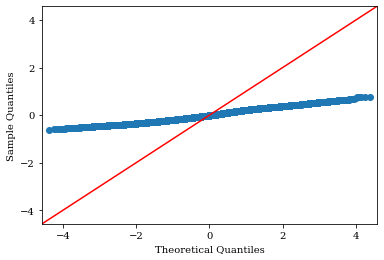

In [24]:
formula_key = 'super_simple'
lms[formula_key], res[formula_key], sos[formula_key] = get_anova(formula_key)

In [9]:
# add the clinal formulae to the factor_names dict - for figures below
for clin_form in res[formula_key]['GF'].index:
    mvp.factor_names.update({clin_form : clin_form})

In [10]:
def create_perc_boxplot(formula_key):
    """Calculate and visualize percent sum of squares from factors."""
    percdf = pd.DataFrame(
        [pd.Series(method_df['perc_sum_sq'], name=method)
         for method, method_df in res[formula_key].items()]
    )

    df = pd.DataFrame(columns=['factor', 'program', 'perc'])
    for factor in percdf.columns:
        for program in percdf.index:
            df.loc[nrow(df)] = [factor, program, percdf.loc[program, factor]]
#     print('set(df.factor) - set(mvp.factor_names) = ', set(df.factor) - set(mvp.factor_names))
#     print('set(mvp.factor_names) - set(df.factor) = ', set(mvp.factor_names) - set(df.factor))

    assert df.factor.notnull().all()

    ax = sns.boxplot(data=df, x='factor', y='perc')
    ax.set_ylabel('percentage sum of squares')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
    ax.set_ylim((0, 100))
    plt.draw()  # so ticklabels populate after changing ylim
    ax.set_yticks(ax.get_yticks())  # supresses FixedLocator warning
    ax.set_title(f'{formula_key = }')
    ax.figure.set_size_inches(10, 5)
    
    # reset ylabels to percentages
    nums = [tick.get_text() for tick in ax.get_yticklabels()]
    ax.set_yticklabels([f'{num}%' for num in nums])
    
    # add horizontal lines
    for y in range(0, 100, 10):
        ax.axhline(y=y, color='gainsboro', zorder=0, alpha=0.3)
    
    mvp.update_ticklabels(ax)
    
    save_pdf(op.join(figdir, f'anova_sos_{formula_key}.pdf'))

    plt.show()       
    
    display(percdf)
    
    return df

percentage sum of squares (super_simple factors)
score ~ cor_TPR_temp + cor_TPR_sal + cor_FPR_temp_neutSNPs + cor_FPR_sal_neutSNPs
architecture = glevel
pleiotropy = plevel_pleio
Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/01_Q1/figs/anova_sos_super_simple.pdf


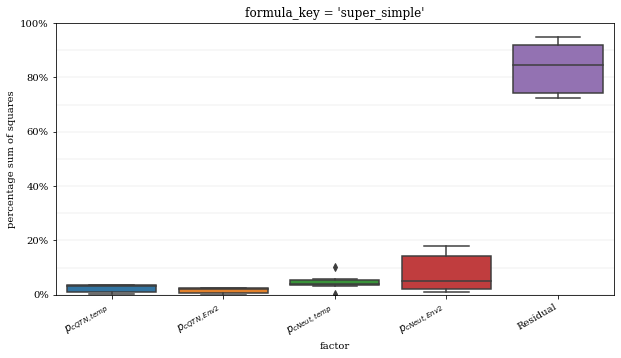

,"$p_{cQTN, temp}$","$p_{cQTN, Env2}$","$p_{cNeut, temp}$","$p_{cNeut, Env2}$",Residual
RONA-sal_opt,0.11,0.07,3.40,1.61,94.82
RONA-temp_opt,3.54,2.47,0.17,0.92,92.91
lfmm2,3.72,2.51,10.40,3.30,80.08
GF,3.69,2.21,3.94,17.89,72.26
rda-nocorr,3.29,1.72,5.93,16.61,72.45
rda-structcorr,0.48,0.35,3.70,6.74,88.72


,factor,program,perc
0,"$p_{cQTN, temp}$",RONA-sal_opt,0.11
1,"$p_{cQTN, temp}$",RONA-temp_opt,3.54
2,"$p_{cQTN, temp}$",lfmm2,3.72
3,"$p_{cQTN, temp}$",GF,3.69
4,"$p_{cQTN, temp}$",rda-nocorr,3.29
5,"$p_{cQTN, temp}$",rda-structcorr,0.48
6,"$p_{cQTN, Env2}$",RONA-sal_opt,0.07
7,"$p_{cQTN, Env2}$",RONA-temp_opt,2.47
8,"$p_{cQTN, Env2}$",lfmm2,2.51
9,"$p_{cQTN, Env2}$",GF,2.21


In [11]:
formula_key = 'super_simple'

print(ColorText(f'percentage sum of squares ({formula_key} factors)').bold())
print(ColorText(formulas[formula_key]).blue())
print('architecture = glevel')
print('pleiotropy = plevel_pleio')

df = create_perc_boxplot(formula_key)

df

In [12]:
formula_key = 'super_simple'

percdf = pd.DataFrame(
    [pd.Series(method_df['perc_sum_sq'], name=method)
     for method, method_df in res[formula_key].items()],
)

# percdf.index = percdf.index.map(mvp.factor_names)
percdf.columns = percdf.columns.map(mvp.factor_names)

percdf

,"$p_{cQTN, temp}$","$p_{cQTN, Env2}$","$p_{cNeut, temp}$","$p_{cNeut, Env2}$",Residual
RONA-sal_opt,0.11,0.07,3.40,1.61,94.82
RONA-temp_opt,3.54,2.47,0.17,0.92,92.91
lfmm2,3.72,2.51,10.40,3.30,80.08
GF,3.69,2.21,3.94,17.89,72.26
rda-nocorr,3.29,1.72,5.93,16.61,72.45
rda-structcorr,0.48,0.35,3.70,6.74,88.72


In [13]:
import importlib
importlib.reload(sys.modules['MVP_summary_functions'])

import MVP_summary_functions as mvp

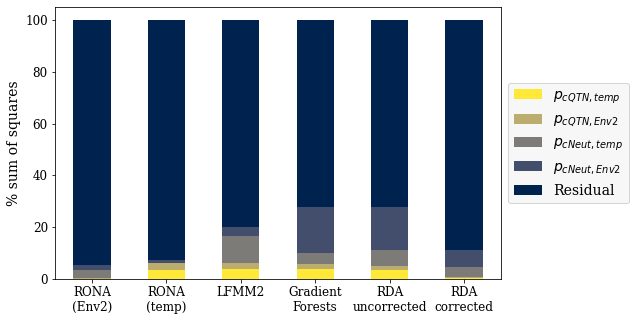

In [14]:
ax = percdf.plot(kind='bar', stacked=True, rot=0, figsize=(8, 5), fontsize=12, cmap='cividis_r')
ax.legend(bbox_to_anchor=(1, 0.5), loc='center left', facecolor='whitesmoke', fontsize=14)
ax.set_ylabel('% sum of squares', fontsize=14)
mvp.update_ticklabels(ax, replace=[(' ', '\n'), ('-', '\n')], fontsize=12)

# ax.legend_.remove()

<AxesSubplot:>

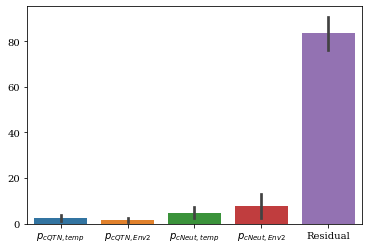

In [15]:
sns.barplot(
    data=percdf,
#     x=
)

<AxesSubplot:>

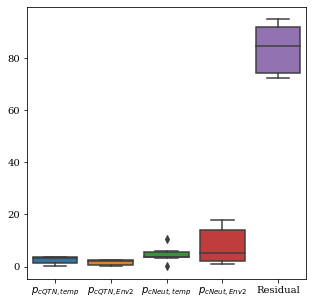

In [16]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.boxplot(
    data=percdf
)

In [17]:
bcs_garden_data.head(2)

,garden,score,glevel,plevel,pleio,slevel,landscape,popsize,migration,marker_set,seed,simulation_level,env,offset_level,program,rep,simulation_garden,final_LA,cor_TPR_temp,cor_TPR_sal,cor_FPR_temp_neutSNPs,cor_FPR_sal_neutSNPs,plevel_pleio,demography,ntraits,noncausal_env,structcrxn
1231109,1,-0.315152,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,all,1231109,highly-polygenic_2-trait_no-pleiotropy_equal-S...,sal_opt,highly-polygenic_2-trait_no-pleiotropy_equal-S...,RONA-sal_opt,0-225,highly-polygenic_2-trait_no-pleiotropy_equal-S...,0.501332,0.495283,0.013652,0.490294,0.0,2-trait_no pleiotropy,N-cline-center-to-edge_m-constant,NaN,NaN,NaN
1231109,2,-0.235152,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,all,1231109,highly-polygenic_2-trait_no-pleiotropy_equal-S...,sal_opt,highly-polygenic_2-trait_no-pleiotropy_equal-S...,RONA-sal_opt,0-225,highly-polygenic_2-trait_no-pleiotropy_equal-S...,0.501332,0.495283,0.013652,0.490294,0.0,2-trait_no pleiotropy,N-cline-center-to-edge_m-constant,NaN,NaN,NaN


# Misc

katie asked me to plot these, keep for records/reference

100%|███████████████| 2250/2250 [00:02<00:00, 802.80it/s]


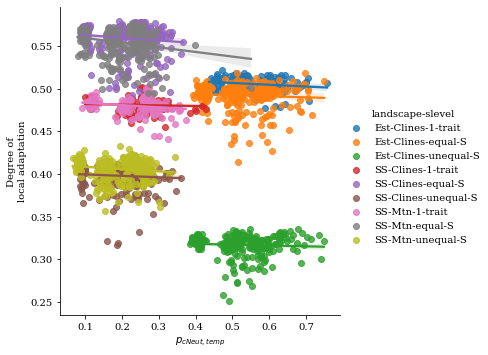

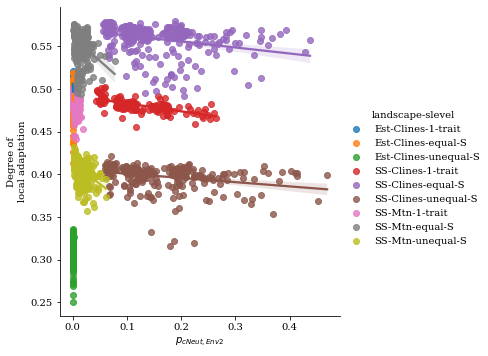

In [18]:
from pythonimports import *

import MVP_summary_functions as mvp

import seaborn as sns

summary = mvp.get_summary_data()
params = mvp.read_params_file()

params['final_LA'] = params.index.map(summary.final_LA)
params['slevel'].fillna('1-trait', inplace=True)
params['landscape-slevel'] = params['landscape'] + '-' + params['slevel']

for pclinal in ['cor_FPR_temp_neutSNPs', 'cor_FPR_sal_neutSNPs']:
    params[pclinal] = params.index.map(summary[pclinal])
    g = sns.lmplot(
        data=params,
        x=pclinal,
        y='final_LA',
        hue='landscape-slevel',
        hue_order=sorted(params['landscape-slevel'].unique())
    )

#     g.ax.invert_yaxis()
    g.ax.set_xlabel(mvp.factor_names[pclinal])
    g.ax.set_ylabel('Degree of\nlocal adaptation')
    plt.show()

In [19]:
params

,level,reps,arch,demog_name,demog_level_sub,demog_level,MIG_x,MIG_y,xcline,ycline,demog,METAPOP_SIDE_x,METAPOP_SIDE_y,Nequal,isVariableM,MIG_breaks,arch_level_sub,arch_level,MU_base,MU_QTL_proportion,SIGMA_QTN_1,SIGMA_QTN_2,SIGMA_K_1,SIGMA_K_2,N_traits,ispleiotropy,seed,final_LA,glevel,plevel,pleio,slevel,landscape,popsize,migration,landscape-slevel,cor_FPR_temp_neutSNPs,cor_FPR_sal_neutSNPs
1231094,highly-polygenic_1-trait__Est-Clines_N-cline-c...,1,highly-polygenic_1-trait,Est-Clines_N-cline-center-to-edge_m-constant,N-cline-center-to-edge_m-constant,Est-Clines,0.49,0.07,linear,linear,Estuary,10,10,4,0,0,1-trait,highly-polygenic,1.000000e-07,0.250,0.002,0.002,0.5,0.5,1,0,1231094,0.500854,highly-polygenic,1-trait,no pleiotropy,1-trait,Est-Clines,N-cline-center-to-edge,m-constant,Est-Clines-1-trait,0.521256,0.000000
1231095,highly-polygenic_1-trait__Est-Clines_N-cline-N...,1,highly-polygenic_1-trait,Est-Clines_N-cline-N-to-S_m-constant,N-cline-N-to-S_m-constant,Est-Clines,0.49,0.07,linear,linear,Estuary,10,10,2,0,0,1-trait,highly-polygenic,1.000000e-07,0.250,0.002,0.002,0.5,0.5,1,0,1231095,0.505075,highly-polygenic,1-trait,no pleiotropy,1-trait,Est-Clines,N-cline-N-to-S,m-constant,Est-Clines-1-trait,0.613016,0.000000
1231096,highly-polygenic_1-trait__Est-Clines_N-equal_m...,1,highly-polygenic_1-trait,Est-Clines_N-equal_m_breaks,N-equal_m_breaks,Est-Clines,0.49,0.07,linear,linear,Estuary,10,10,0,0,1,1-trait,highly-polygenic,1.000000e-07,0.250,0.002,0.002,0.5,0.5,1,0,1231096,0.499265,highly-polygenic,1-trait,no pleiotropy,1-trait,Est-Clines,N-equal,m-breaks,Est-Clines-1-trait,0.533427,0.000000
1231097,highly-polygenic_1-trait__Est-Clines_N-equal_m...,1,highly-polygenic_1-trait,Est-Clines_N-equal_m-constant,N-equal_m-constant,Est-Clines,0.49,0.07,linear,linear,Estuary,10,10,0,0,0,1-trait,highly-polygenic,1.000000e-07,0.250,0.002,0.002,0.5,0.5,1,0,1231097,0.499365,highly-polygenic,1-trait,no pleiotropy,1-trait,Est-Clines,N-equal,m-constant,Est-Clines-1-trait,0.452379,0.000000
1231098,highly-polygenic_1-trait__Est-Clines_N-variabl...,1,highly-polygenic_1-trait,Est-Clines_N-variable_m-variable,N-variable_m-variable,Est-Clines,0.49,0.07,linear,linear,Estuary,10,10,3,1,0,1-trait,highly-polygenic,1.000000e-07,0.250,0.002,0.002,0.5,0.5,1,0,1231098,0.501054,highly-polygenic,1-trait,no pleiotropy,1-trait,Est-Clines,N-variable,m-variable,Est-Clines-1-trait,0.633769,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1233339,oligogenic_2-trait-pleiotropy-unequal-S__SS-Mt...,10,oliogenic_2-trait-pleiotropy-unequal-S,SS-Mtn_N-cline-center-to-edge_m-constant,N-cline-center-to-edge_m-constant,SS-Mtn,0.03,0.03,V,linear,SS,10,10,4,0,0,2-trait-pleiotropy-unequal-S,oliogenic,1.000000e-07,0.001,0.400,0.400,0.5,4.0,2,1,1233339,0.378143,oligogenic,2-trait,pleiotropy,unequal-S,SS-Mtn,N-cline-center-to-edge,m-constant,SS-Mtn-unequal-S,0.171797,0.019925
1233340,oligogenic_2-trait-pleiotropy-unequal-S__SS-Mt...,10,oliogenic_2-trait-pleiotropy-unequal-S,SS-Mtn_N-cline-N-to-S_m-constant,N-cline-N-to-S_m-constant,SS-Mtn,0.03,0.03,V,linear,SS,10,10,2,0,0,2-trait-pleiotropy-unequal-S,oliogenic,1.000000e-07,0.001,0.400,0.400,0.5,4.0,2,1,1233340,0.386475,oligogenic,2-trait,pleiotropy,unequal-S,SS-Mtn,N-cline-N-to-S,m-constant,SS-Mtn-unequal-S,0.218248,0.008493
1233341,oligogenic_2-trait-pleiotropy-unequal-S__SS-Mt...,10,oliogenic_2-trait-pleiotropy-unequal-S,SS-Mtn_N-equal_m_breaks,N-equal_m_breaks,SS-Mtn,0.03,0.03,V,linear,SS,10,10,0,0,1,2-trait-pleiotropy-unequal-S,oliogenic,1.000000e-07,0.001,0.400,0.400,0.5,4.0,2,1,1233341,0.406991,oligogenic,2-trait,pleiotropy,unequal-S,SS-Mtn,N-equal,m-breaks,SS-Mtn-unequal-S,0.222313,0.001944
1233342,oligogenic_2-trait-pleiotropy-unequal-S__SS-Mt...,10,oliogenic_2-trait-pleiotropy-unequal-S,SS-Mtn_N-equal_m-constant,N-equal_m-constant,SS-Mtn,0.03,0.03,V,linear,SS,10,10,0,0,0,2-trait-pleiotropy-unequal-S,oliogen

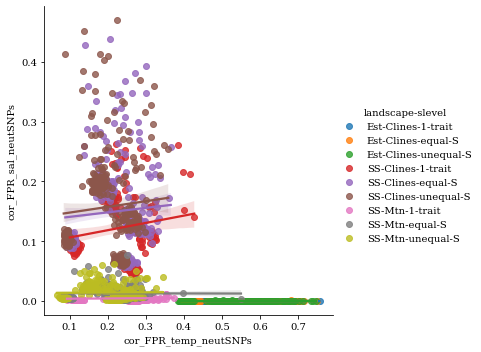

In [20]:
sns.lmplot(
    data=params,
    x='cor_FPR_temp_neutSNPs',
    y='cor_FPR_sal_neutSNPs',
    hue='landscape-slevel',
    hue_order=sorted(params['landscape-slevel'].unique())
#     palette=mvp.boxplot_kwargs['palette']
)

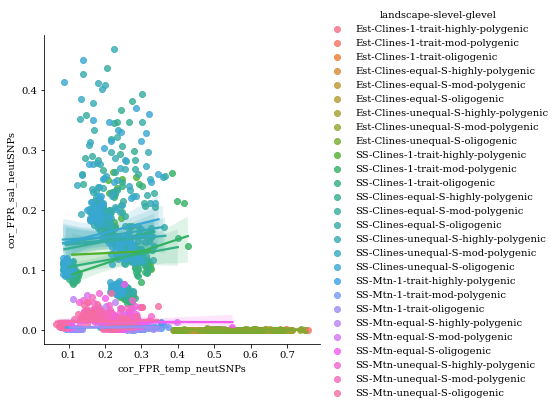

In [21]:
params['landscape-slevel-glevel'] = params['landscape-slevel'] + '-' + params.glevel
sns.lmplot(
    data=params,
    x='cor_FPR_temp_neutSNPs',
    y='cor_FPR_sal_neutSNPs',
    hue='landscape-slevel-glevel',
    hue_order=sorted(params['landscape-slevel-glevel'].unique())
)

In [22]:
formatclock(dt.now() - t0)

'0-00:00:39'